##Houghton County Substance Use Facility Accessibility Analysis

In [ ]:
##Houghton County Substance Use Facility Accessibility Analysis

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects

In [14]:
# File paths
# -------------------------------
county_fp = r"E:\Substanace_Use\county.shp"
facilities_fp = r"E:\Substanace_Use\Substance_Use_Disorder_Care.csv"
output_dir = r"E:\Substanace_Use"


In [24]:
# 1. Load Michigan counties shapefile
# -------------------------------
counties = gpd.read_file(county_fp)
print(f"Michigan County CRS: {counties.crs}")

# Extract Houghton County
houghton = counties[counties['Name'].str.lower() == 'houghton']
print(f"Houghton CRS before projection: {houghton.crs}")

# Reproject to UTM for accurate distance buffering
houghton = houghton.to_crs(epsg=26916)
print(f"Houghton CRS after projection: {houghton.crs}")

Michigan County CRS: EPSG:3078
Houghton CRS before projection: EPSG:3078
Houghton CRS after projection: EPSG:26916


Michigan County CRS: EPSG:3078
Houghton CRS before projection: EPSG:3078
Houghton CRS after projection: EPSG:26916


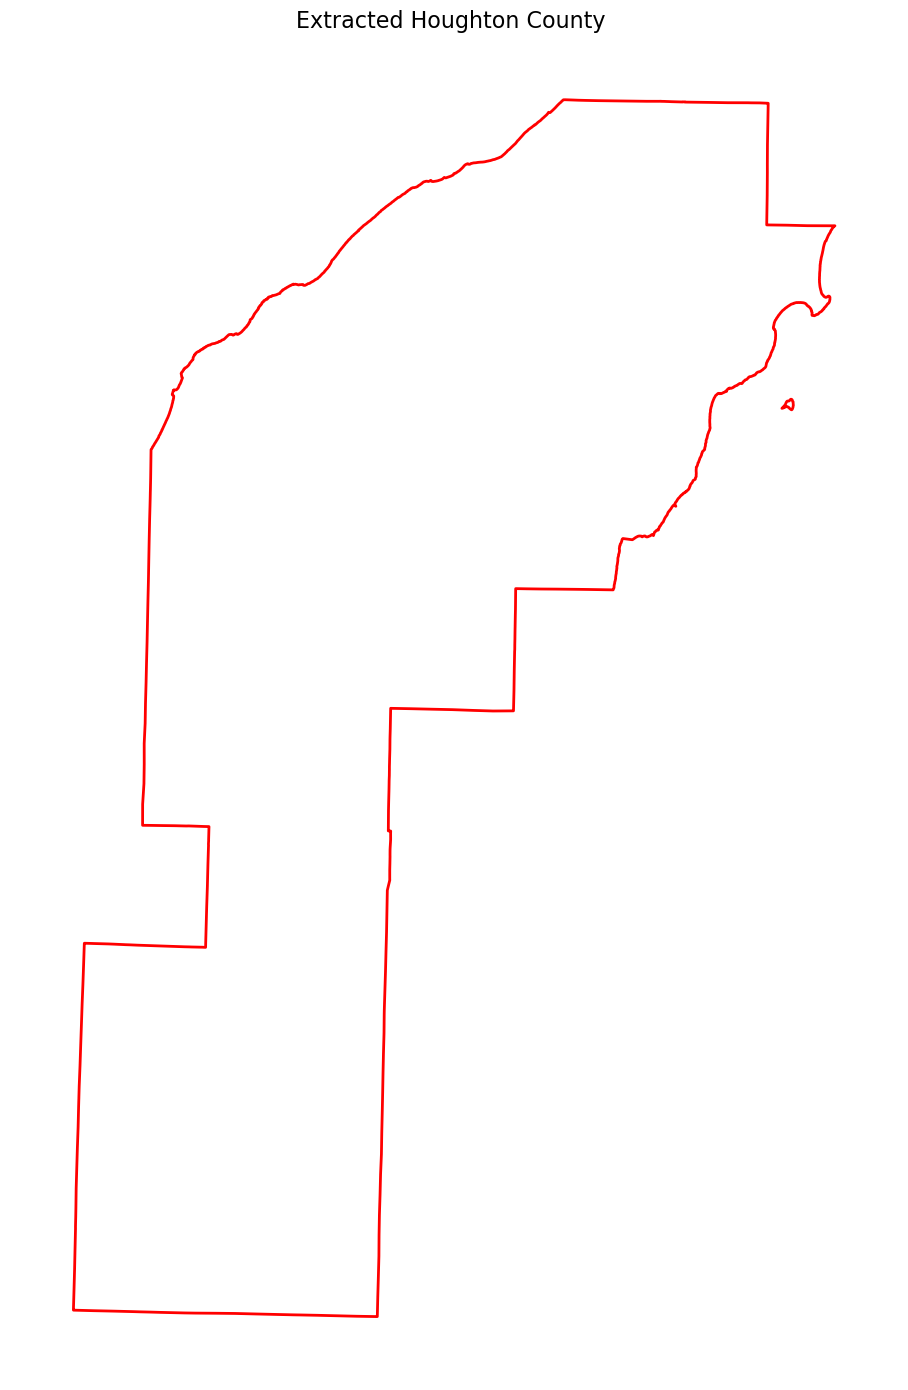

In [ ]:


# -------------------------------
# Plot all Michigan counties and highlight Houghton
# -------------------------------
# Zoomable map in Jupyter
# %matplotlib notebook  # Uncomment in Jupyter Notebook for interactive zoom

fig, ax = plt.subplots(figsize=(14,14))
counties.boundary.plot(ax=ax, edgecolor='gray', linewidth=0.5)
houghton.boundary.plot(ax=ax, edgecolor='red', linewidth=2)

# Zoom into Houghton
xmin, ymin, xmax, ymax = houghton.total_bounds
ax.set_xlim(xmin - 5000, xmax + 5000)
ax.set_ylim(ymin - 5000, ymax + 5000)

ax.set_title("Extracted Houghton County ", fontsize=16)
ax.set_axis_off()
plt.tight_layout()
plt.savefig(f"{output_dir}/Michigan_Houghton.png", dpi=300)
plt.show()

In [25]:
# 2. Load facility CSV and clean column names
# -------------------------------
facilities_df = pd.read_csv(facilities_fp)
facilities_df.columns = facilities_df.columns.str.strip()

facilities_gdf = gpd.GeoDataFrame(
    facilities_df,
    geometry=gpd.points_from_xy(facilities_df['Longitude'], facilities_df['Latitude']),
    crs="EPSG:4326"
)
print(f"Facility CRS before projection: {facilities_gdf.crs}")

# Reproject to match Houghton CRS
facilities_gdf = facilities_gdf.to_crs(houghton.crs)
print(f"Facility CRS after projection: {facilities_gdf.crs}")

Facility CRS before projection: EPSG:4326
Facility CRS after projection: EPSG:26916


In [26]:
# 3. Filter facilities inside Houghton County
# -------------------------------
facilities_houghton = gpd.sjoin(facilities_gdf, houghton, how="inner", predicate='within')
if 'Name_left' in facilities_houghton.columns:
    facilities_houghton = facilities_houghton.rename(columns={'Name_left':'Name'})

# Assign numbers for labeling
facilities_houghton = facilities_houghton.reset_index(drop=True)
facilities_houghton['ID'] = facilities_houghton.index + 1




In [ ]:
# 4. Create buffers around each facility (1, 3, 5 miles)
# -------------------------------
buffer_distances = [1, 3, 5]  # in miles
colors = {1:'blue', 3:'green', 5:'purple'}
markers = ['^', 's', 'o', 'D', 'v', '*', 'P']
mile_to_meter = 1609.34

buffers = {}
for d in buffer_distances:
    buffers[d] = facilities_houghton.copy()
    buffers[d]['geometry'] = buffers[d]['geometry'].buffer(d * mile_to_meter)
    # Save buffer shapefiles
    buffers[d].to_file(f"{output_dir}/Houghton_{d}mile_buffer.shp")

C:\Users\myami\AppData\Local\Temp\ipykernel_18652\2431157881.py:13: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  buffers[d].to_file(f"{output_dir}/Houghton_{d}mile_buffer.shp")
C:\Users\myami\AppData\Local\Temp\ipykernel_18652\2431157881.py:13: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  buffers[d].to_file(f"{output_dir}/Houghton_{d}mile_buffer.shp")
C:\Users\myami\AppData\Local\Temp\ipykernel_18652\2431157881.py:13: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  buffers[d].to_file(f"{output_dir}/Houghton_{d}mile_buffer.shp")


In [ ]:
#5. Function to plot maps with numbered facility labels and CRS display
# -------------------------------
def plot_map(county, facilities, buffer_gdf=None, buffer_distance=None, save_name="map.png"):
    fig, ax = plt.subplots(figsize=(14,14))
    
    # County outline
    county.boundary.plot(ax=ax, edgecolor='black', linewidth=1.5)
    
    # Buffer polygons
    if buffer_gdf is not None and buffer_distance is not None:
        buffer_gdf.boundary.plot(ax=ax, edgecolor=colors[buffer_distance],
                                 linestyle='--', linewidth=2, label=f'{buffer_distance}-mile Accessibility Buffer')
    
    # Facilities with marker cycling
    for idx, row in facilities.iterrows():
        marker = markers[idx % len(markers)]
        ax.scatter(row.geometry.x, row.geometry.y, color='red', s=150, marker=marker)
    
    # Numbered labels with white halo
    for x, y, label in zip(facilities.geometry.x, facilities.geometry.y, facilities['ID']):
        txt = ax.text(x, y, str(label), fontsize=14, fontweight='bold', ha='center', va='center', color='white')
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='black')])
    
    # Legend outside with facility names
    legend_items = [mpatches.Patch(color='none', label=f"{row['ID']}: {row['Name']}") 
                    for idx, row in facilities.iterrows()]
    ax.legend(handles=legend_items, loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Title
    title = f"Houghton County - Facilities with {buffer_distance}-mile Accessibility Buffer" if buffer_distance else "Houghton County - Facilities"
    ax.set_title(title + f"\nCRS: {county.crs}", fontsize=16)
    
    ax.set_axis_off()
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{save_name}", dpi=300, bbox_inches='tight')
    plt.show()


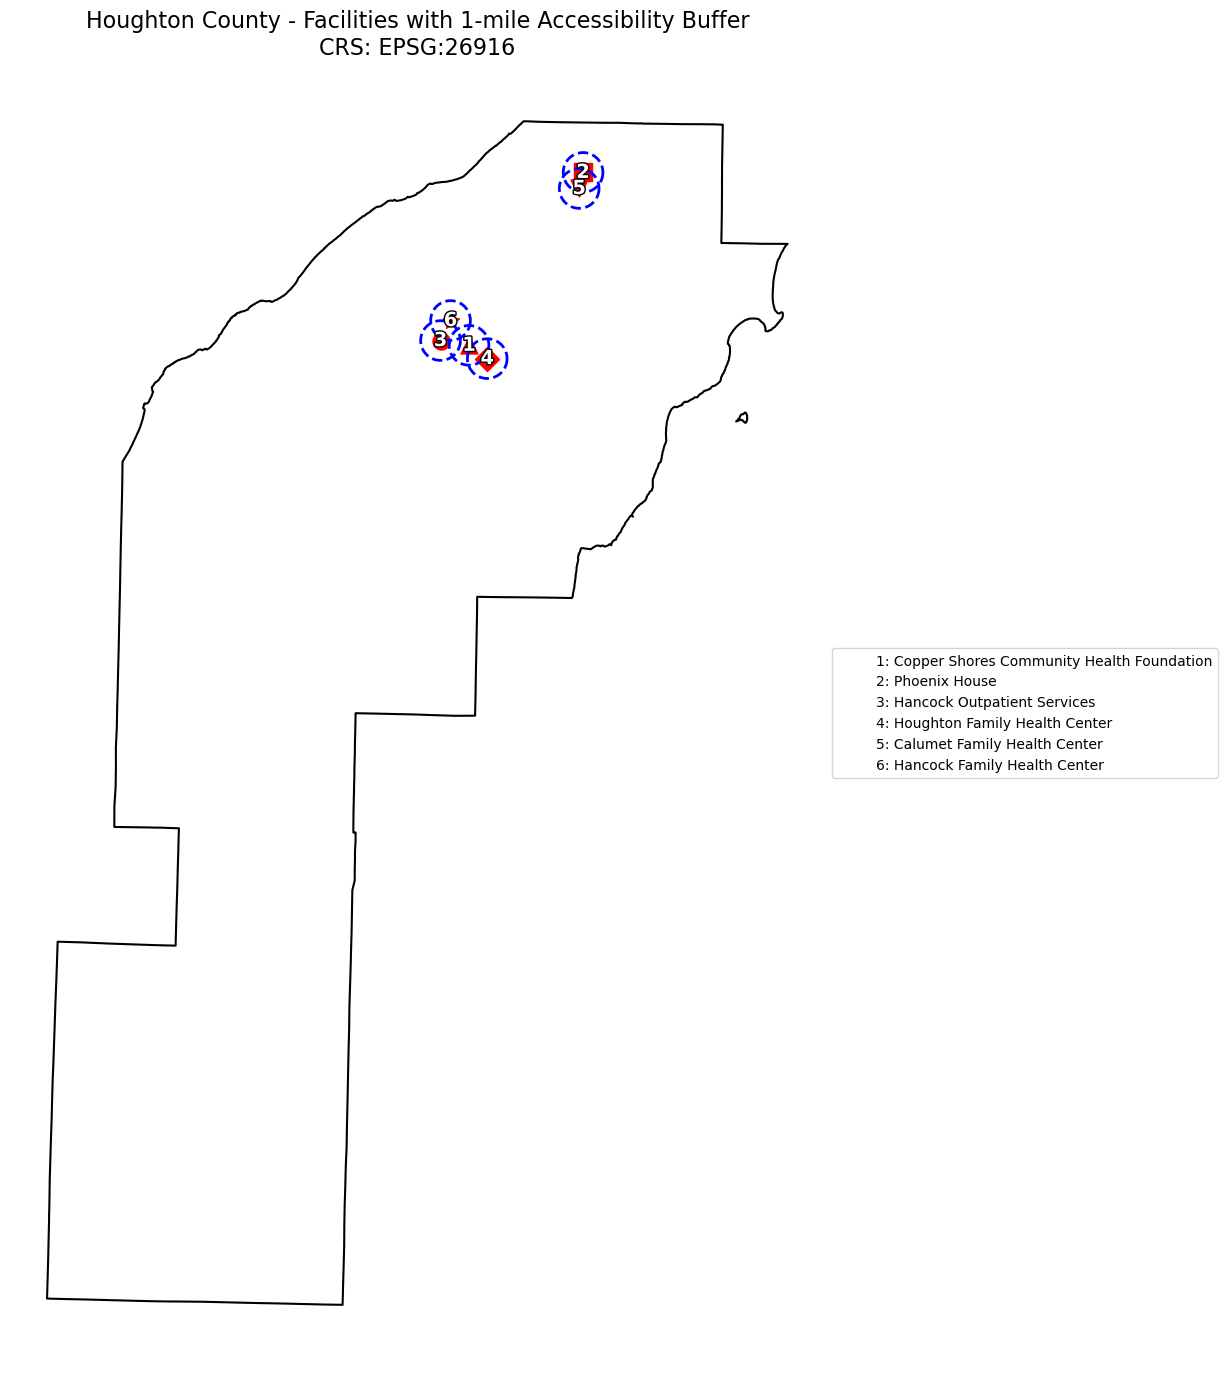

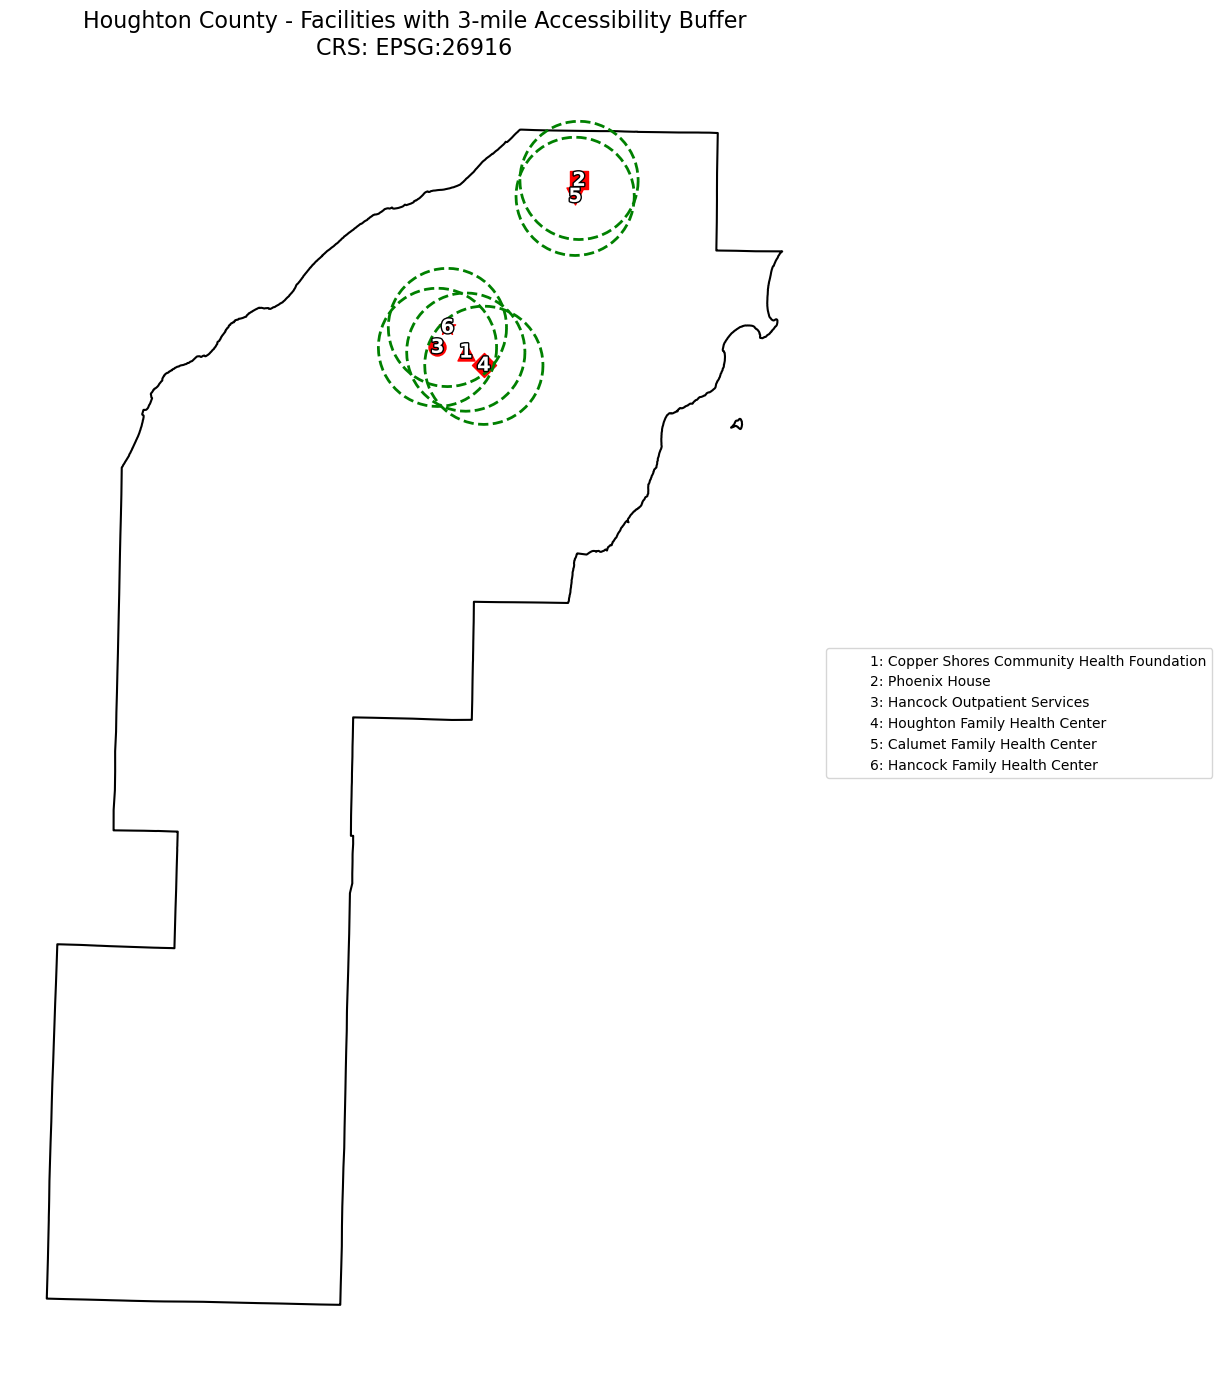

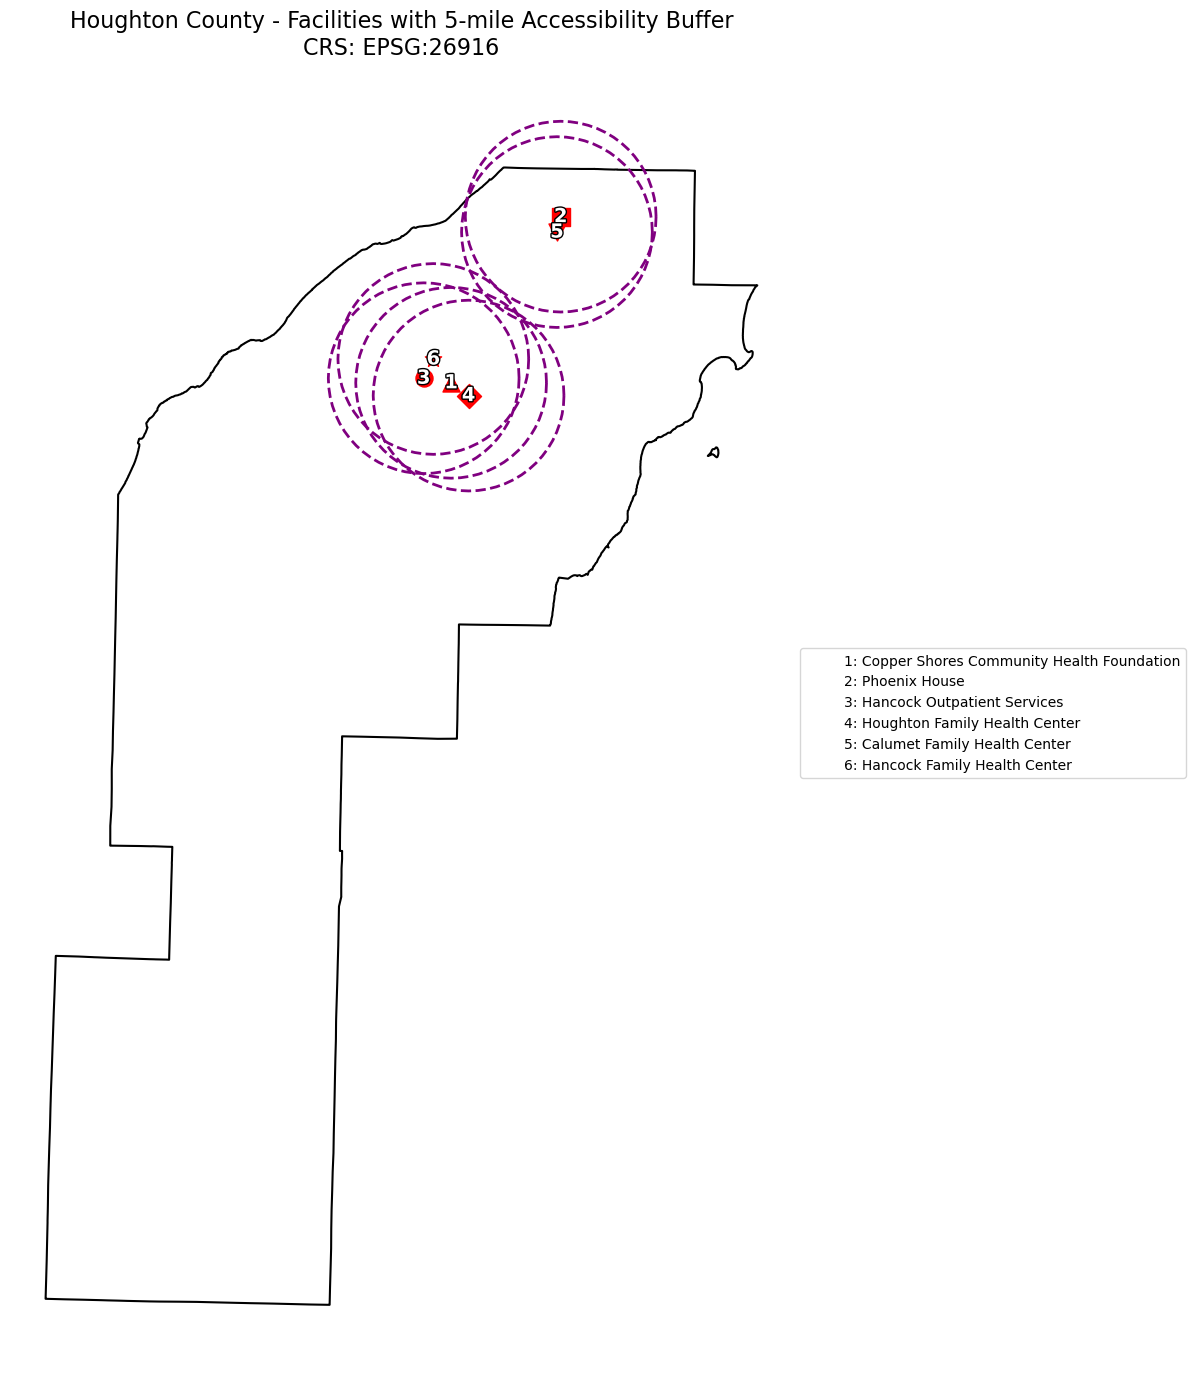

In [29]:
# 6. Plot individual buffer maps
# -------------------------------
for d in buffer_distances:
    plot_map(houghton, facilities_houghton, buffers[d], d, f"Houghton_{d}mile_buffer.png")


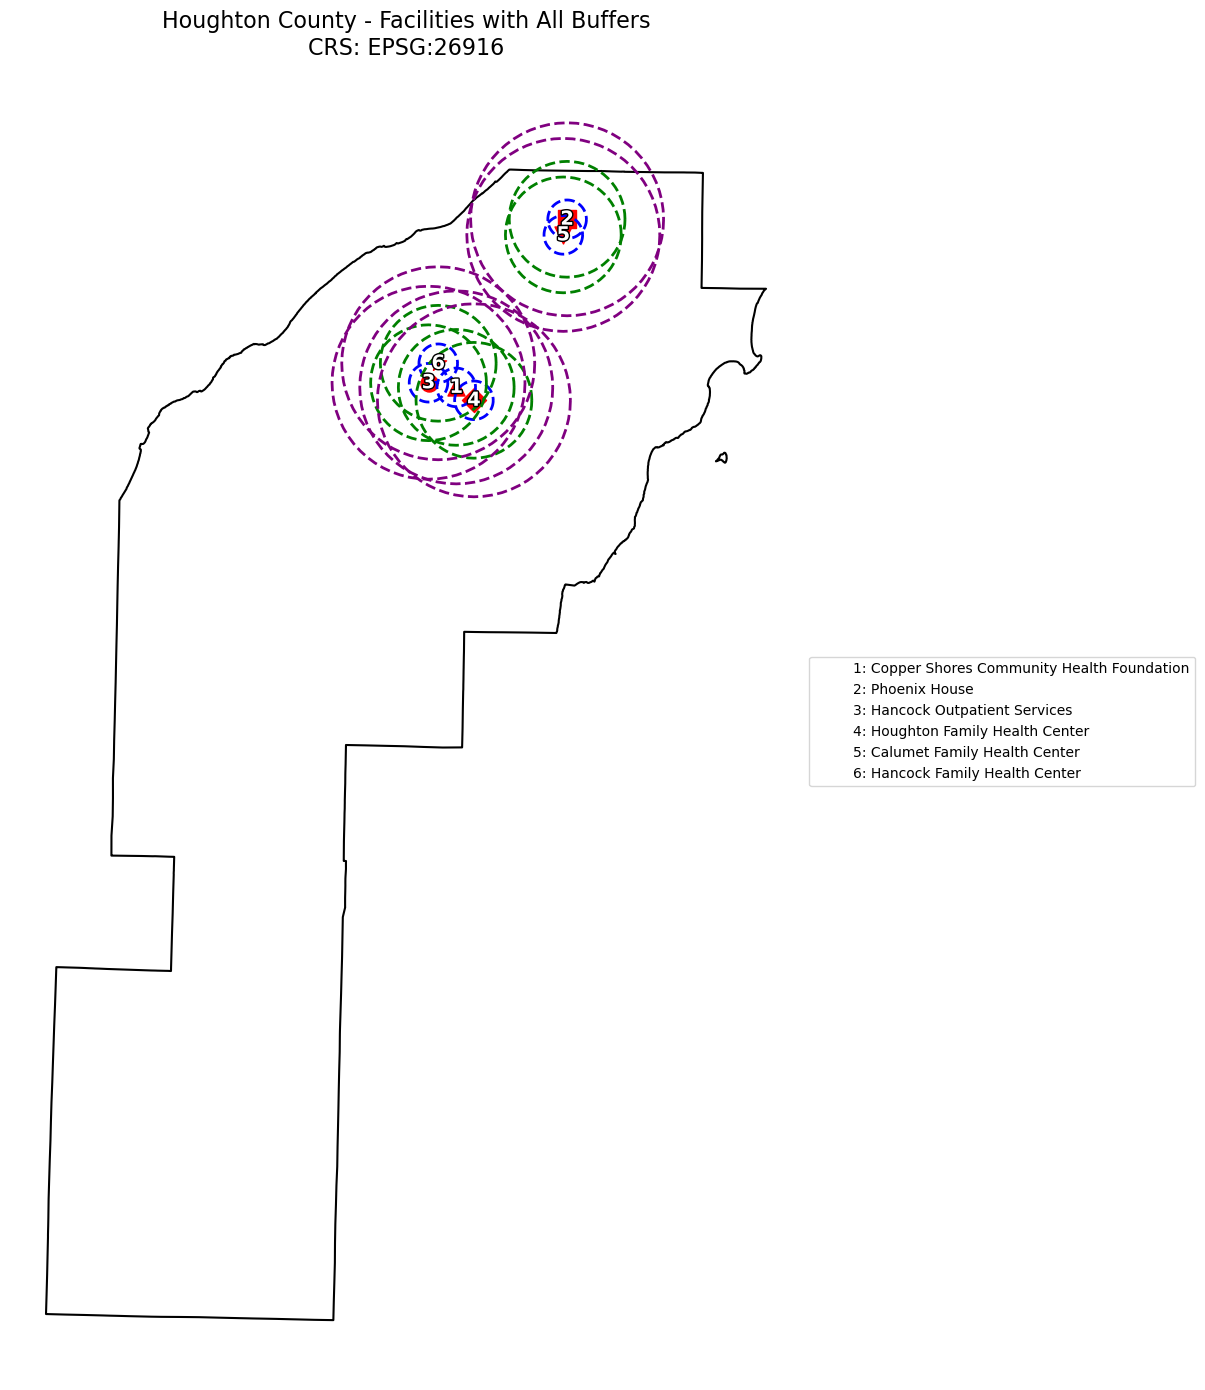

In [30]:
# 7. Plot all buffers together
# -------------------------------
fig, ax = plt.subplots(figsize=(14,14))
houghton.boundary.plot(ax=ax, edgecolor='black', linewidth=1.5)

for idx, row in facilities_houghton.iterrows():
    marker = markers[idx % len(markers)]
    ax.scatter(row.geometry.x, row.geometry.y, color='red', s=150, marker=marker)

for d in buffer_distances:
    buffers[d].boundary.plot(ax=ax, edgecolor=colors[d], linestyle='--', linewidth=2, label=f'{d}-mile Accessibility Buffer')

for x, y, label in zip(facilities_houghton.geometry.x, facilities_houghton.geometry.y, facilities_houghton['ID']):
    txt = ax.text(x, y, str(label), fontsize=14, fontweight='bold', ha='center', va='center', color='white')
    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='black')])

legend_items = [mpatches.Patch(color='none', label=f"{row['ID']}: {row['Name']}") 
                for idx, row in facilities_houghton.iterrows()]
ax.legend(handles=legend_items, loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_title("Houghton County - Facilities with All Buffers\nCRS: {}".format(houghton.crs), fontsize=16)
ax.set_axis_off()
plt.tight_layout()
plt.savefig(f"{output_dir}/Houghton_All_Buffers.png", dpi=300, bbox_inches='tight')
plt.show()

In [31]:
# 8. Calculate coverage statistics based on area (as accessibility proxy)
# -------------------------------
houghton_area = houghton.geometry.area.sum()

coverage_summary = []

for d in buffer_distances:
    union_buffer = buffers[d].unary_union
    intersection = houghton.geometry.intersection(union_buffer)
    covered_area = intersection.area.sum()
    percent_covered = (covered_area / houghton_area) * 100
    coverage_summary.append({
        'Buffer_miles': d,
        'County_area_sqm': houghton_area,
        'Covered_area_sqm': covered_area,
        'Percent_covered': percent_covered,
        'Number_of_facilities': len(buffers[d])
    })
    print(f"{d}-mile buffer: {percent_covered:.2f}% of Houghton County covered, {len(buffers[d])} facilities")

coverage_df = pd.DataFrame(coverage_summary)
coverage_df.to_csv(f"{output_dir}/Houghton_Buffer_Coverage_Summary.csv", index=False)

1-mile buffer: 1.40% of Houghton County covered, 6 facilities
3-mile buffer: 7.70% of Houghton County covered, 6 facilities
5-mile buffer: 17.24% of Houghton County covered, 6 facilities


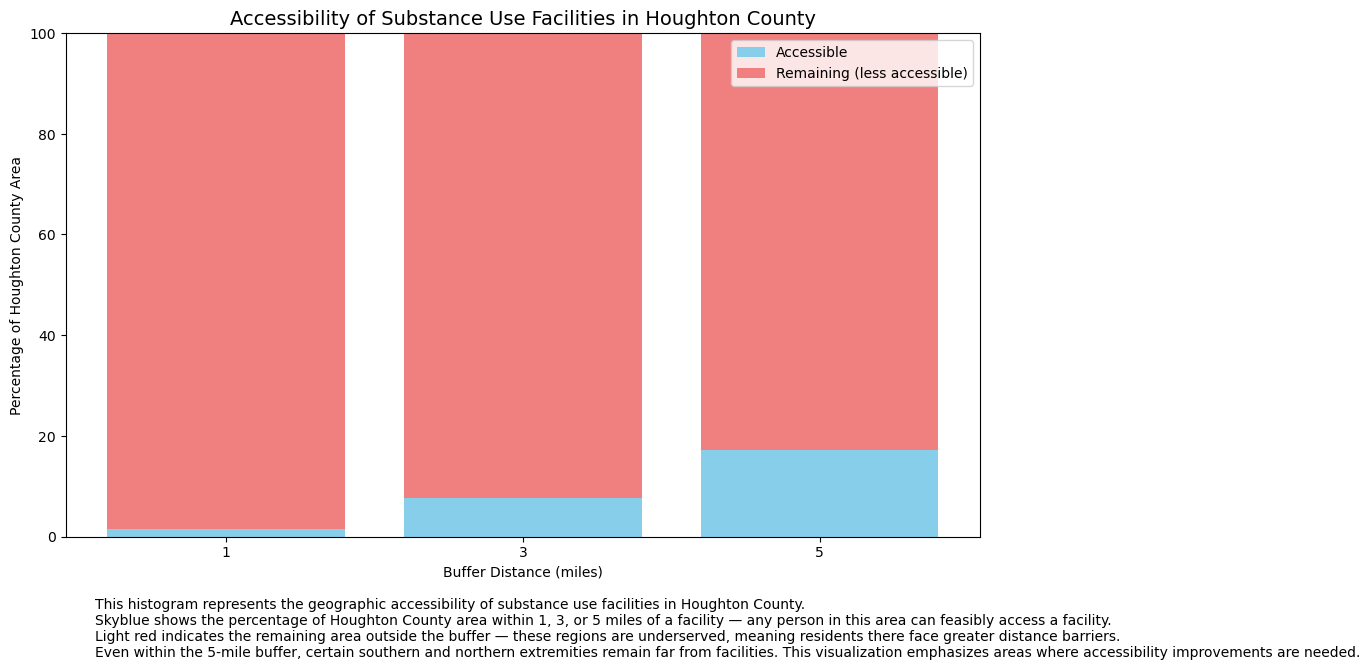

In [32]:
# 9. Histogram of accessibility with detailed explanation below
# -------------------------------
coverage_df['Percent_non_accessible'] = 100 - coverage_df['Percent_covered']

plt.figure(figsize=(10,6))
plt.bar(coverage_df['Buffer_miles'].astype(str), coverage_df['Percent_covered'], color='skyblue', label='Accessible')
plt.bar(coverage_df['Buffer_miles'].astype(str), coverage_df['Percent_non_accessible'], 
        bottom=coverage_df['Percent_covered'], color='lightcoral', label='Remaining (less accessible)')

plt.xlabel("Buffer Distance (miles)")
plt.ylabel("Percentage of Houghton County Area")
plt.title("Accessibility of Substance Use Facilities in Houghton County", fontsize=14)
plt.ylim(0,100)
plt.legend(loc='upper right')

# Detailed explanation below histogram
explanation_text = (
    "This histogram represents the geographic accessibility of substance use facilities in Houghton County.\n"
    "Skyblue shows the percentage of Houghton County area within 1, 3, or 5 miles of a facility — any person in this area can feasibly access a facility.\n"
    "Light red indicates the remaining area outside the buffer — these regions are underserved, meaning residents there face greater distance barriers.\n"
    "Even within the 5-mile buffer, certain southern and northern extremities remain far from facilities. This visualization emphasizes areas where accessibility improvements are needed."
)
plt.figtext(0.1, -0.1, explanation_text, wrap=True, fontsize=10)

plt.tight_layout()
plt.savefig(f"{output_dir}/Houghton_Buffer_Coverage_Histogram_Detailed.png", dpi=300)
plt.show()